In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# https://www.statsmodels.org/stable/index.html
import statsmodels.api as sm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from functools import partial

In [9]:
from dotenv import load_dotenv

from pathlib import Path

env_path = Path("../../.env-live")

if env_path.exists():
    print('envs Loaded')
    load_dotenv(dotenv_path=env_path)
from jrjModelRegistry.jrjModelRegistry import registerAJrjModel

envs Loaded
Pinged your deployment. You successfully connected to MongoDB!


In [10]:
def generalRegressionPredictor(self, transformedData):
    return self.predict(transformedData)

In [11]:
spamDf = pd.read_excel("./Spam.xlsx")
# spamDf = pd.read_excel("https://www.dropbox.com/scl/fi/v24mmhg5hmefmnv99uqsy/Spam.xlsx?rlkey=iq7exnueq84sy7y2b8ud70mp0&dl=1")
spamDf

,Record,Spam,Recipients,Hyperlinks,Characters
0,1,0,19,1,47
1,2,0,15,1,58
2,3,1,13,11,88
3,4,1,17,11,68
4,5,0,15,1,87
...,...,...,...,...,...
495,496,0,15,2,97
496,497,0,20,5,72
497,498,1,41,11,52
498,499,1,16,11,74


In [12]:
spamDf.size, spamDf.shape

(2500, (500, 5))

In [13]:
evaluationBinaryCalssifiactionSampleData = {
    "Recipients": [19, 15, 13],
    "Hyperlinks": [1, 1, 11],
    "Characters": [47, 58, 88]
}

In [16]:
def evaluationBinaryCalssifiactionTransformer(dataForTransfer = None):
    import pandas as pd
    import statsmodels.api as sm
    if isinstance(dataForTransfer, pd.DataFrame):
        df = dataForTransfer.copy()
    else:
        df = pd.DataFrame(dataForTransfer)
    dfTransformer = sm.add_constant(df[["Recipients", "Hyperlinks", "Characters"]],has_constant='add')
    return dfTransformer

In [21]:
from sklearn.model_selection import train_test_split

In [23]:
# Split the dataset into training and testing sets
trainSet, testSet = train_test_split(
  spamDf,
  test_size=0.3,
  random_state=1,
  stratify=spamDf['Spam']
)
trainSet.shape, testSet.shape

((350, 5), (150, 5))

In [25]:
# Fit the logistic regression model
features = ['Recipients', 'Hyperlinks', 'Characters']
xTrain = trainSet[features]
yTrain = trainSet['Spam'].astype(int)
yTest = testSet['Spam'].astype(int)

In [27]:
model1 = sm.Logit(
  yTrain,
  evaluationBinaryCalssifiactionTransformer(xTrain)
)
model1Fit = model1.fit()
print(model1Fit.summary())

Optimization terminated successfully.
         Current function value: 0.430522
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Spam   No. Observations:                  350
Model:                          Logit   Df Residuals:                      346
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Jun 2025   Pseudo R-squ.:                  0.3784
Time:                        02:47:00   Log-Likelihood:                -150.68
converged:                       True   LL-Null:                       -242.40
Covariance Type:            nonrobust   LLR p-value:                 1.606e-39
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3440      0.757     -5.741      0.000      -5.827      -2.861
Recipients     0.1071      0.

In [30]:
predict1 = model1Fit.predict(evaluationBinaryCalssifiactionTransformer(testSet))
testSet['predict1'] = predict1
sumTable = pd.DataFrame({'A': testSet['Spam'], 'Prob': testSet['predict1']})
sumTable.to_csv("ROC.csv", index=True)


In [32]:
testSet['predict1']

186    0.739633
423    0.079193
369    0.712801
283    0.838428
266    0.789240
         ...   
156    0.850576
54     0.180012
322    0.376942
314    0.040472
296    0.102076
Name: predict1, Length: 150, dtype: float64

In [34]:
sumTable1 = pd.DataFrame({'A': testSet['Spam'], 'Prob': testSet['predict1']})

In [36]:
# Make predictions based on probability threshold of 0.5
testSet['predictions'] = (testSet['predict1'] > 0.5).astype(int)
sumTable1['P'] = testSet['predictions']
sumTable1

,A,Prob,P
186,0,0.739633,1
423,0,0.079193,0
369,1,0.712801,1
283,1,0.838428,1
266,1,0.789240,1
...,...,...,...
156,1,0.850576,1
54,0,0.180012,0
322,0,0.376942,0
314,0,0.040472,0


In [38]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve

In [40]:
# Calculate accuracy
accuracy = accuracy_score(sumTable1['A'], sumTable1['P'])
print(f'Accuracy: {accuracy}')

Accuracy: 0.78


In [42]:
# Calculate recall
recall = recall_score(sumTable1['A'], sumTable1['P'])
print(f'Recall: {recall}')

Recall: 0.7532467532467533


In [44]:
# Calculate precision
precision = precision_score(sumTable1['A'], sumTable1['P'])
print(f'Precision: {precision}')

Precision: 0.8055555555555556


In [46]:
# Sensitivity and Specificity (Sensitivity is same as recall)
sensitivity = recall
specificity = sum((sumTable1['A'] == 0) & (sumTable1['P'] == 0)) / sum(sumTable1['A'] == 0)
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Sensitivity: 0.7532467532467533
Specificity: 0.8082191780821918


In [48]:
# Calculate F1 Score
f1Score = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1Score}')

F1 Score: 0.778523489932886


In [50]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(testSet['Spam'], testSet['predict1'])
roc_auc = roc_auc_score(testSet['Spam'], testSet['predict1'])
# Calculate AUC
print(f'AUC: {roc_auc}')


AUC: 0.8305461661626046


In [52]:
import matplotlib.pyplot as plt

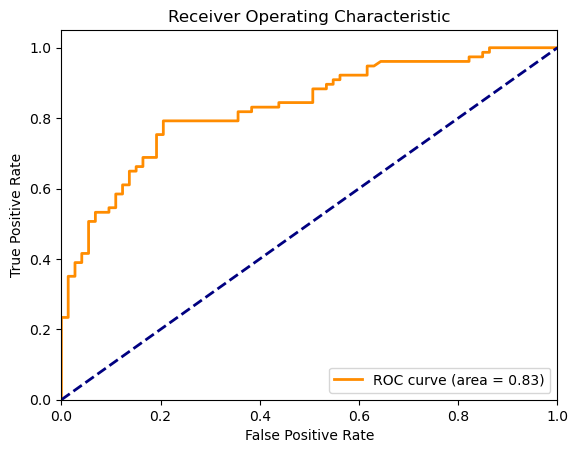

In [54]:

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [56]:
model1Fit.transformer = evaluationBinaryCalssifiactionTransformer
model1Fit.mainPredictor = partial(generalRegressionPredictor, model1Fit)
registerAJrjModel(
    model1Fit,
    {
        "modelName":f"raoyi_li_evaluationBinaryCalssifiactionModelWithExteraMetircs",
        "version":"1.0.1",
        "params": model1Fit.params.to_dict(),
        "score": accuracy,
        "otherEvaluationMetrics": {
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "f1Score": f1Score,
            "roc_auc": roc_auc,
        },
        "modelLibrary": "statsmodels.api.Logit",
        "libraryMetadata": {
            "pvalues": model1Fit.pvalues.to_dict(),
            "pseudo_r_squared": float(model1Fit.prsquared),
            "llf": float(model1Fit.llf),
            "aic": float(model1Fit.aic),
            "bic": float(model1Fit.bic)
        },
    
        "sampleData": {
            "dataForTransfer": evaluationBinaryCalssifiactionSampleData
        }
    }
)

✅ Uploaded encrypted ZIP to s3://273-g2/raoyi_li_evaluationBinaryCalssifiactionModelWithExteraMetircs__1.0.1.pkl.zip


{'_id': '685c989416ab41d65cc7834d',
 'modelName': 'raoyi_li_evaluationBinaryCalssifiactionModelWithExteraMetircs',
 'version': '1.0.1',
 'params': {'const': -4.344003369483712,
  'Recipients': 0.1071186036456391,
  'Hyperlinks': 0.5802500387118026,
  'Characters': -0.01322097062725321},
 'score': 0.78,
 'otherEvaluationMetrics': {'accuracy': 0.78,
  'recall': 0.7532467532467533,
  'precision': 0.8055555555555556,
  'sensitivity': 0.7532467532467533,
  'specificity': 0.8082191780821918,
  'f1Score': 0.778523489932886,
  'roc_auc': 0.8305461661626046},
 'modelLibrary': 'statsmodels.api.Logit',
 'libraryMetadata': {'pvalues': {'const': 9.422806741188288e-09,
   'Recipients': 0.002051015207263913,
   'Hyperlinks': 8.11444020327352e-23,
   'Characters': 0.031251010008406285},
  'pseudo_r_squared': 0.37836014568360676,
  'llf': -150.682864074958,
  'aic': 309.365728149916,
  'bic': 324.7974607678498},
 'sampleData': {'dataForTransfer': {'Recipients': [19, 15, 13],
   'Hyperlinks': [1, 1, 11]

## DT

In [59]:
def generalDtPredictor(self, transformedData):
    import pandas as pd
    probs = self.predict_proba(transformedData)
    return pd.Series(probs[:, 1])

In [61]:
def generalDtTransformer(dataForTransfer = None):
    import pandas as pd
    if isinstance(dataForTransfer, pd.DataFrame):
        df = dataForTransfer.copy()
    else:
        df = pd.DataFrame(dataForTransfer)
    return df

In [63]:
from sklearn.tree import DecisionTreeClassifier

In [65]:
dt = DecisionTreeClassifier()


In [67]:
dt.fit(evaluationBinaryCalssifiactionTransformer(xTrain), yTrain)

DecisionTreeClassifier()

In [69]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

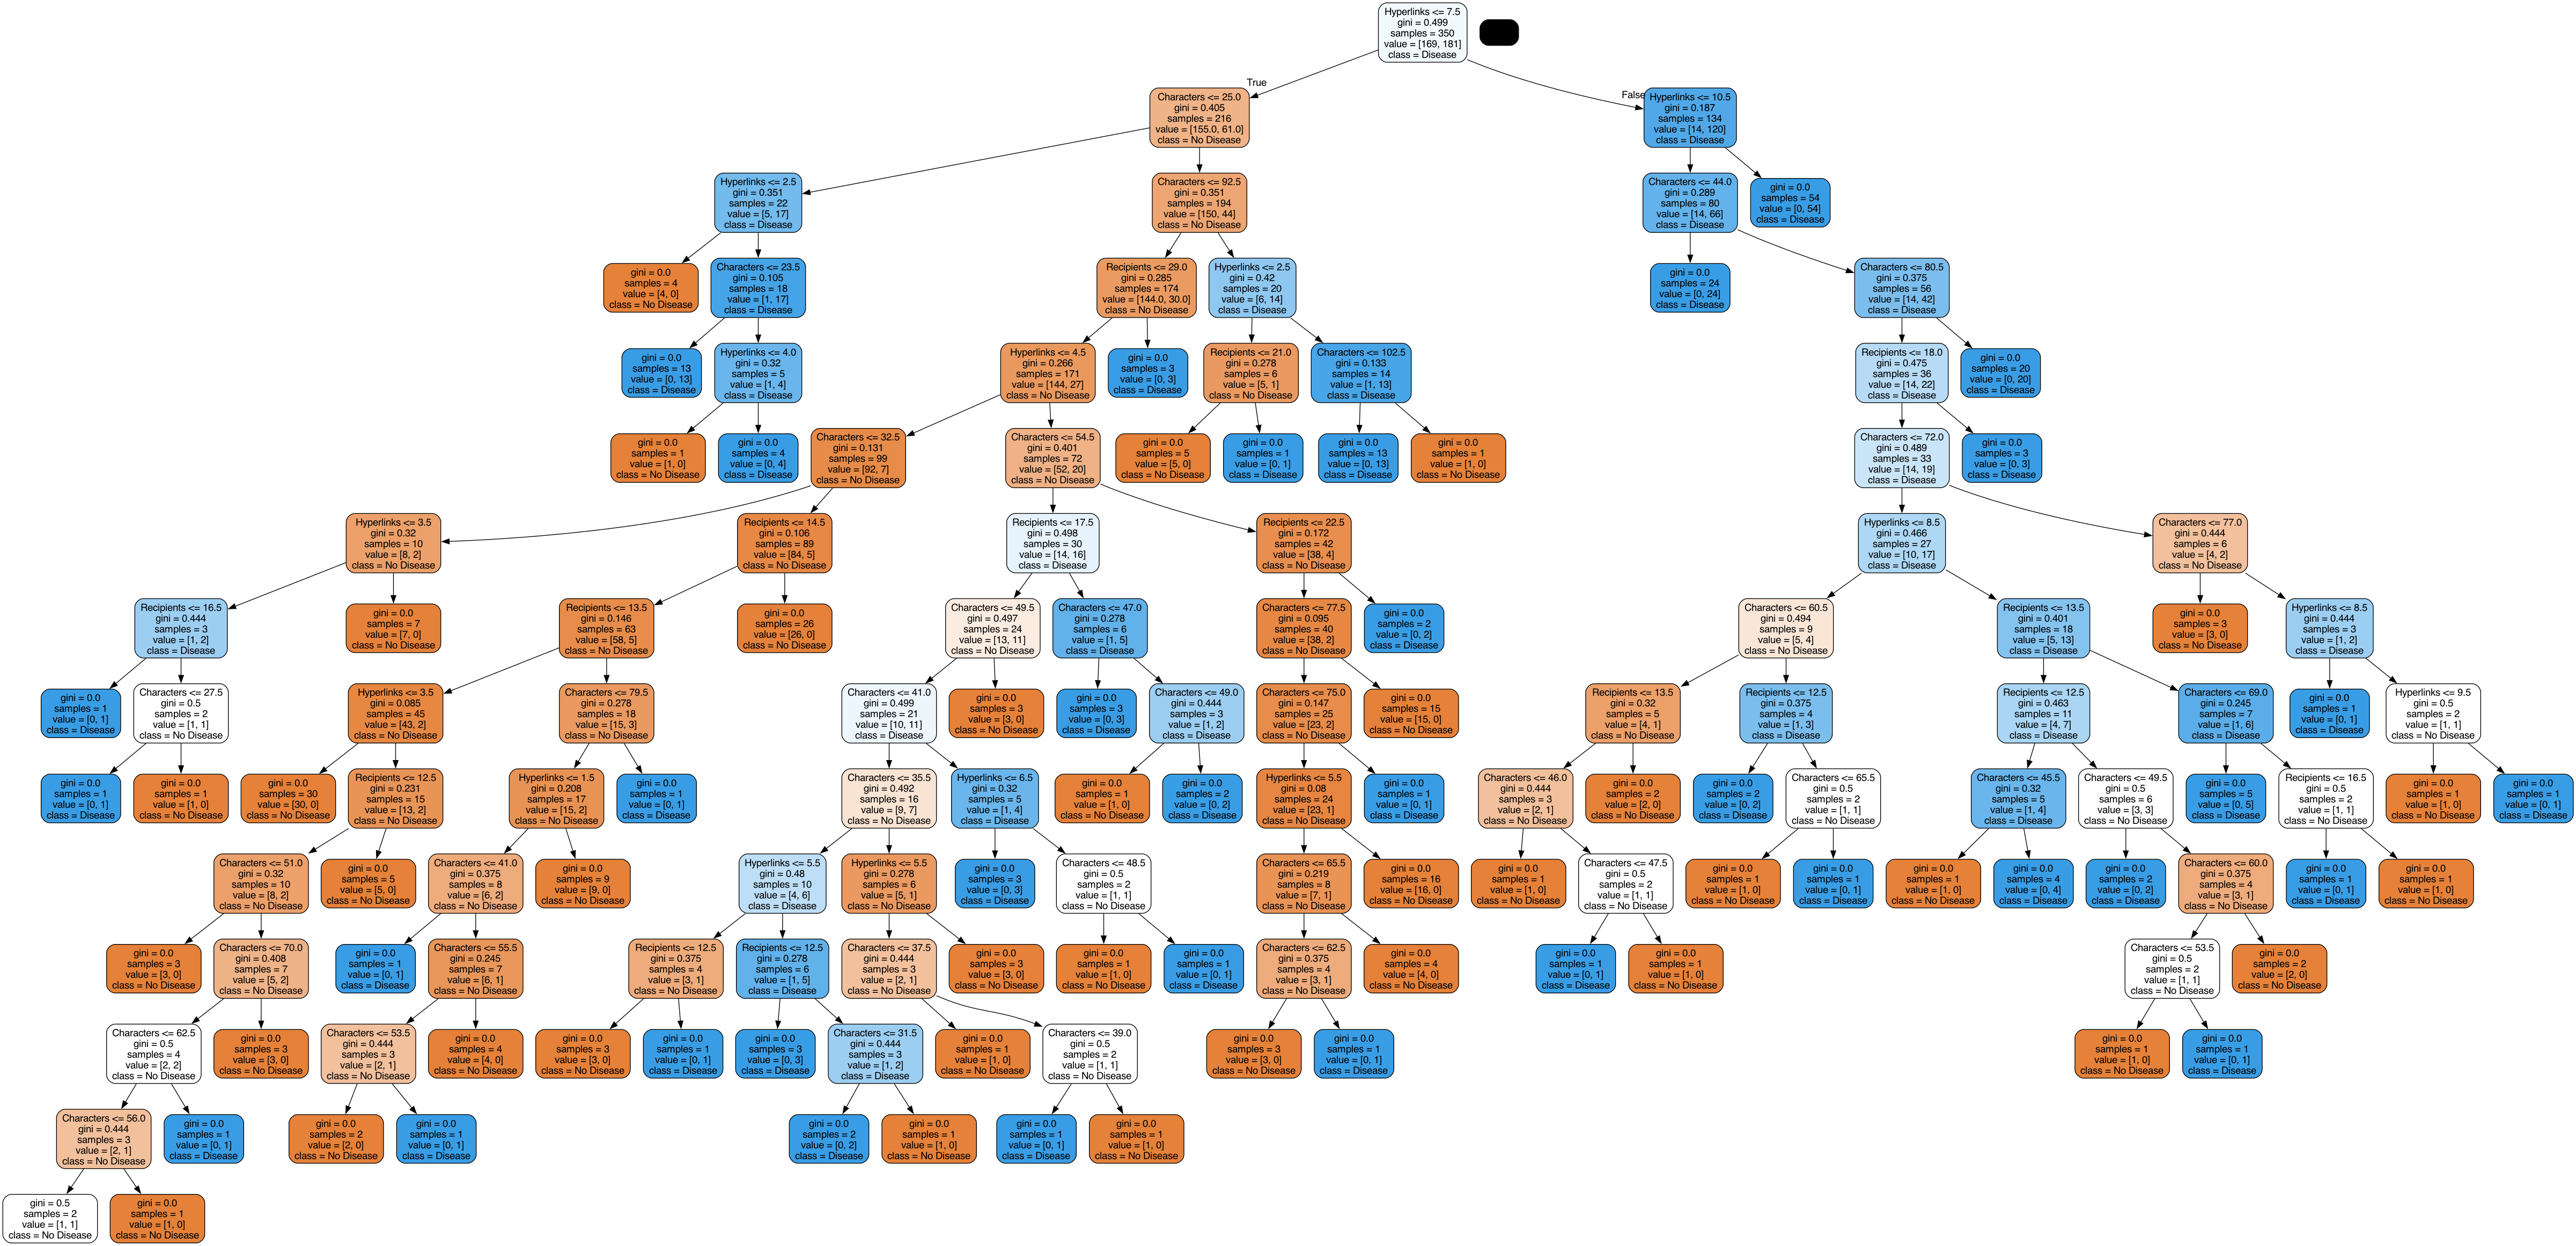

In [71]:
# plotting tree with max_depth=3
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data, filled=True, rounded=True,
                feature_names=evaluationBinaryCalssifiactionTransformer(xTrain).columns, 
                class_names=['No Disease', "Disease"])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
#Image(graph.create_png(),width=800,height=900)
#graph.write_pdf("dt_heartdisease.pdf")

In [73]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [75]:
y_train_pred = dt.predict(evaluationBinaryCalssifiactionTransformer(xTrain))
y_test_pred = dt.predict(evaluationBinaryCalssifiactionTransformer(testSet))

In [77]:
# y_train_pred

In [79]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [81]:
print(accuracy_score(yTrain, y_train_pred))
confusion_matrix(yTrain, y_train_pred)

0.9971428571428571


array([[169,   0],
       [  1, 180]])

In [83]:
print(accuracy_score(yTest, y_test_pred))
confusion_matrix(yTest, y_test_pred)

0.7933333333333333


array([[58, 15],
       [16, 61]])

In [85]:
from sklearn.metrics import classification_report

In [87]:
dt.transformer = evaluationBinaryCalssifiactionTransformer
dt.mainPredictor = partial(generalDtPredictor,dt)

In [89]:
y_pred = dt.predict(evaluationBinaryCalssifiactionTransformer(evaluationBinaryCalssifiactionTransformer(testSet)))
# y_pred
score = accuracy_score(yTest, y_pred)
# score
report = classification_report(yTest, y_pred, output_dict=True)
# report

In [91]:
dt_metadata = {
    "modelName": "raoyi_li_evaluationBinaryCalssifiactionModelDt",
    "version": "1.0.1",
    "params": dt.get_params(),  # All model hyperparameters
    "score": float(score),         # Accuracy
    "modelLibrary": "sklearn.tree.DecisionTreeClassifier",
    "libraryMetadata": {
        "feature_importances": dt.feature_importances_.tolist(),
        "n_features": int(dt.n_features_in_),
        "n_classes": int(dt.n_classes_),
        "classes": dt.classes_.tolist(),
        "depth": int(dt.get_depth()),
        "n_leaves": int(dt.get_n_leaves()),
        "classification_report": report
    },
     "sampleData": {
        "dataForTransfer": evaluationBinaryCalssifiactionSampleData
    }
}

In [93]:
registerAJrjModel(
    dt,
    dt_metadata
)

✅ Uploaded encrypted ZIP to s3://273-g2/raoyi_li_evaluationBinaryCalssifiactionModelDt__1.0.1.pkl.zip


{'_id': '685c98ad16ab41d65cc7834e',
 'modelName': 'raoyi_li_evaluationBinaryCalssifiactionModelDt',
 'version': '1.0.1',
 'params': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'monotonic_cst': None,
  'random_state': None,
  'splitter': 'best'},
 'score': 0.7933333333333333,
 'modelLibrary': 'sklearn.tree.DecisionTreeClassifier',
 'libraryMetadata': {'feature_importances': [0.0,
   0.099831047721305,
   0.5050884398347356,
   0.3950805124439594],
  'n_features': 4,
  'n_classes': 2,
  'classes': [0, 1],
  'depth': 14,
  'n_leaves': 74,
  'classification_report': {'0': {'precision': 0.7837837837837838,
    'recall': 0.7945205479452054,
    'f1-score': 0.7891156462585034,
    'support': 73.0},
   '1': {'precision': 0.8026315789473685,
    'recall': 0.7922077922077922,
    'f1-sc

In [95]:
dt1 = DecisionTreeClassifier(min_samples_leaf=20, random_state=42, criterion="entropy")


In [97]:
dt1.fit(evaluationBinaryCalssifiactionTransformer(xTrain), yTrain)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20,
                       random_state=42)

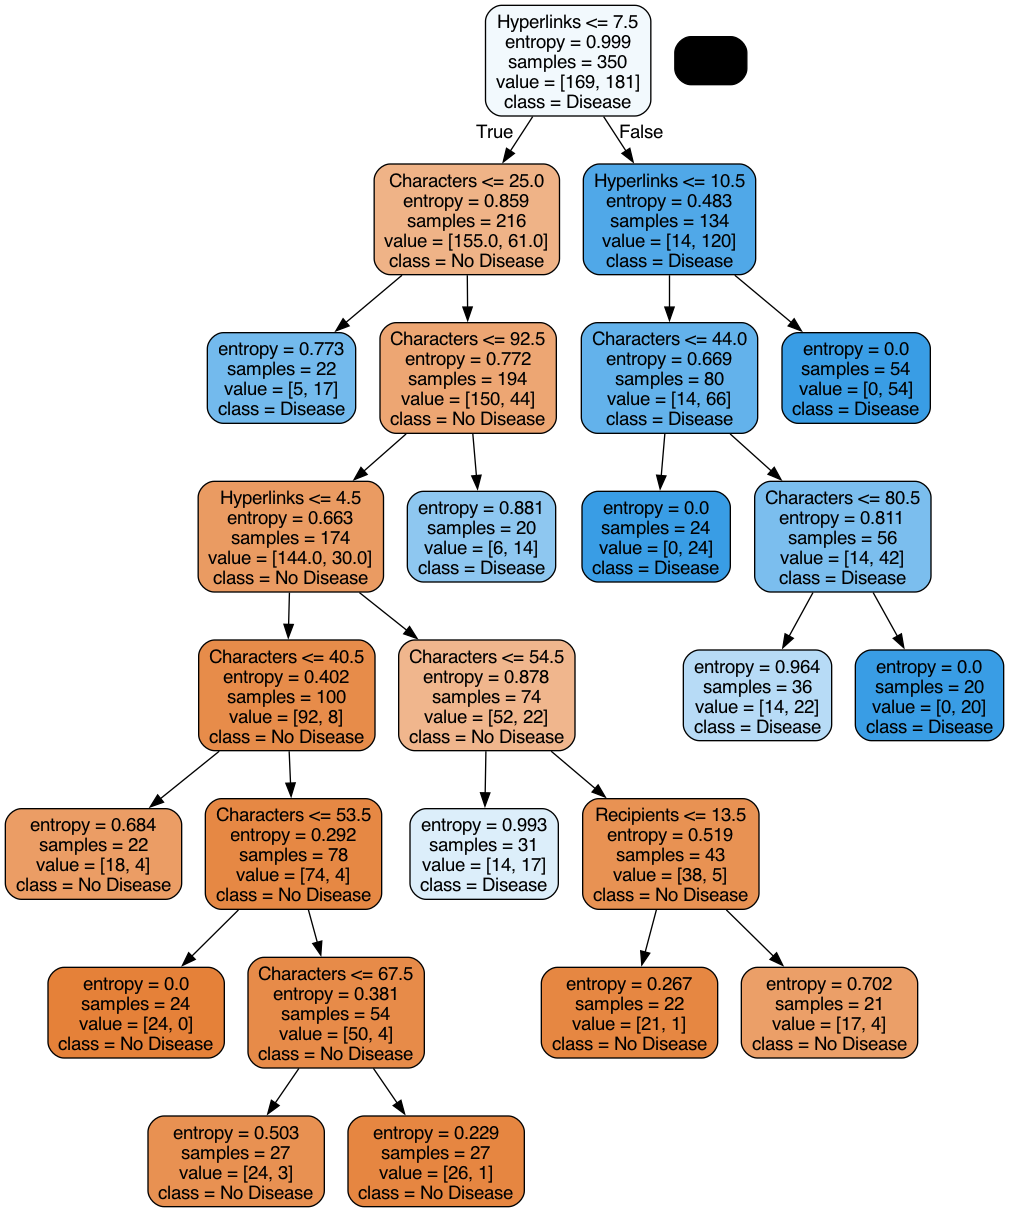

In [99]:
dot_data = StringIO()  

export_graphviz(dt1, out_file=dot_data, filled=True, rounded=True,
                feature_names=evaluationBinaryCalssifiactionTransformer(xTrain).columns, 
                class_names=['No Disease', "Disease"])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
#Image(graph.create_png(),width=800,height=900)
#graph.write_pdf("dt_heartdisease.pdf")

In [101]:
dt1.transformer = evaluationBinaryCalssifiactionTransformer
dt1.mainPredictor = partial(generalDtPredictor,dt1)
y_pred = dt.predict(evaluationBinaryCalssifiactionTransformer(evaluationBinaryCalssifiactionTransformer(testSet)))
# y_pred
score = accuracy_score(yTest, y_pred)
# score
report = classification_report(yTest, y_pred, output_dict=True)
# report
dt1_metadata = {
    "modelName": "raoyi_li_evaluationBinaryCalssifiactionModelDt1",
    "version": "1.0.1",
    "params": dt1.get_params(),  # All model hyperparameters
    "score": float(score),         # Accuracy
    "modelLibrary": "sklearn.tree.DecisionTreeClassifier",
    "libraryMetadata": {
        "feature_importances": dt1.feature_importances_.tolist(),
        "n_features": int(dt1.n_features_in_),
        "n_classes": int(dt1.n_classes_),
        "classes": dt1.classes_.tolist(),
        "depth": int(dt1.get_depth()),
        "n_leaves": int(dt1.get_n_leaves()),
        "classification_report": report
    },
     "sampleData": {
        "dataForTransfer": evaluationBinaryCalssifiactionSampleData
    }
}

In [103]:
registerAJrjModel(
    dt1,
    dt1_metadata
)

✅ Uploaded encrypted ZIP to s3://273-g2/raoyi_li_evaluationBinaryCalssifiactionModelDt1__1.0.1.pkl.zip


{'_id': '685c98c016ab41d65cc7834f',
 'modelName': 'raoyi_li_evaluationBinaryCalssifiactionModelDt1',
 'version': '1.0.1',
 'params': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 20,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'monotonic_cst': None,
  'random_state': 42,
  'splitter': 'best'},
 'score': 0.7933333333333333,
 'modelLibrary': 'sklearn.tree.DecisionTreeClassifier',
 'libraryMetadata': {'feature_importances': [0.0,
   0.00864252595909053,
   0.6227917495150891,
   0.3685657245258203],
  'n_features': 4,
  'n_classes': 2,
  'classes': [0, 1],
  'depth': 7,
  'n_leaves': 13,
  'classification_report': {'0': {'precision': 0.7837837837837838,
    'recall': 0.7945205479452054,
    'f1-score': 0.7891156462585034,
    'support': 73.0},
   '1': {'precision': 0.8026315789473685,
    'recall': 0.7922077922077922,
    'f